# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [1]:
import requests
import zipfile
import io
import pandas as pd
import os # ファイル/ディレクトリ操作用

# 1. データセットのダウンロードと展開
sst2_zip_url = "https://dl.fbaipublicfiles.com/glue/data/SST-2.zip"
download_dir = "../data/SST-2_data" # ダウンロードしたファイルを展開するディレクトリ名
train_file_path = os.path.join(download_dir, "SST-2/train.tsv")
dev_file_path = os.path.join(download_dir, "SST-2/dev.tsv")

# ディレクトリがなければ作成
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    print(f"ディレクトリ '{download_dir}' を作成しました。")

try:
    print(f"'{sst2_zip_url}' からSST-2データセットをダウンロードしています...")
    response = requests.get(sst2_zip_url)
    response.raise_for_status() # エラーチェック
    
    print("ダウンロード完了。zipファイルを展開しています...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(download_dir) # 指定したディレクトリに展開
    print(f"SST-2データセットを '{download_dir}' に展開しました。")

except requests.exceptions.RequestException as e:
    print(f"データセットのダウンロード中にエラーが発生しました: {e}")
except zipfile.BadZipFile:
    print("エラー: ダウンロードしたファイルが正しいzipファイルではありません。")
except Exception as e:
    print(f"データセットの処理中に予期せぬエラーが発生しました: {e}")


# 3. データの読み込みとラベル数のカウント
def count_labels(file_path, dataset_name):
    """指定されたTSVファイルを読み込み、ラベルの数をカウントして表示する関数"""
    try:
        df = pd.read_csv(file_path, sep='\t')
        print(f"\n--- {dataset_name} ({os.path.basename(file_path)}) ---")
        print("最初の数行:")
        print(df.head())
        print("\nラベルごとの事例数:")
        print(df['label'].value_counts())
        return df['label'].value_counts()
    except FileNotFoundError:
        print(f"エラー: ファイル '{file_path}' が見つかりません。ダウンロードと展開が正しく行われたか確認してください。")
        return None
    except KeyError:
        print(f"エラー: ファイル '{file_path}' に 'label' 列が見つかりません。ファイルの形式を確認してください。")
        return None
    except Exception as e:
        print(f"ファイル '{file_path}' の処理中にエラーが発生しました: {e}")
        return None

# train.tsv のラベル数をカウント
print("\n--- 学習データ (train.tsv) ---")
train_label_counts = count_labels(train_file_path, "学習データ")

# dev.tsv のラベル数をカウント
print("\n--- 検証データ (dev.tsv) ---")
dev_label_counts = count_labels(dev_file_path, "検証データ")

# (オプション) 結果をまとめて表示
if train_label_counts is not None:
    print(f"\n学習データのポジティブ(1)事例数: {train_label_counts.get(1, 0)}")
    print(f"学習データのネガティブ(0)事例数: {train_label_counts.get(0, 0)}")

if dev_label_counts is not None:
    print(f"\n検証データのポジティブ(1)事例数: {dev_label_counts.get(1, 0)}")
    print(f"検証データのネガティブ(0)事例数: {dev_label_counts.get(0, 0)}")

ディレクトリ '../data/SST-2_data' を作成しました。
'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip' からSST-2データセットをダウンロードしています...
ダウンロード完了。zipファイルを展開しています...
SST-2データセットを '../data/SST-2_data' に展開しました。

--- 学習データ (train.tsv) ---

--- 学習データ (train.tsv) ---
最初の数行:
                                            sentence  label
0       hide new secretions from the parental units       0
1               contains no wit , only labored gags       0
2  that loves its characters and communicates som...      1
3  remains utterly satisfied to remain the same t...      0
4  on the worst revenge-of-the-nerds clichés the ...      0

ラベルごとの事例数:
label
1    37569
0    29780
Name: count, dtype: int64

--- 検証データ (dev.tsv) ---

--- 検証データ (dev.tsv) ---
最初の数行:
                                            sentence  label
0    it 's a charming and often affecting journey .       1
1                 unflinchingly bleak and desperate       0
2  allows us to hope that nolan is poised to emba...      1
3  the acting , costumes ,

## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [2]:
import pandas as pd
from collections import Counter
import os # ファイルパスの操作にosモジュールを使用

# --- 設定箇所 (ご自身の環境に合わせて確認・修正してください) ---
# 問題60でSST-2データを展開した親ディレクトリへのパス
# 例: Notebookファイルと同じ階層に 'SST-2_data' を作成し、その中に展開した場合
base_data_dir = '../data/SST-2_data' # このパスは 'nlp100_2025/data/SST-2_data' に相当する場合もあります

# train.tsv と dev.tsv へのフルパスを構築
# SST-2.zipを展開すると、通常 'SST-2' というサブディレクトリ内にファイルができます。
train_file_path = os.path.join(base_data_dir, "SST-2/train.tsv")
dev_file_path = os.path.join(base_data_dir, "SST-2/dev.tsv")
# --- 設定箇所ここまで ---

# DataFrameを格納する変数を初期化
df_train = None
df_dev = None

# TSVファイルの読み込み
try:
    df_train = pd.read_csv(train_file_path, sep='\t')
    df_dev = pd.read_csv(dev_file_path, sep='\t')
    print(f"'{train_file_path}' (学習データ) を読み込みました。件数: {len(df_train)}")
    print(f"'{dev_file_path}' (検証データ) を読み込みました。件数: {len(df_dev)}")
except FileNotFoundError:
    print(f"エラー: ファイルが見つかりません。")
    print(f"train_file_path: {train_file_path}")
    print(f"dev_file_path: {dev_file_path}")
    print("上記のパスに train.tsv と dev.tsv が存在するか確認してください。")
    print("問題60のデータダウンロード・展開が正しく完了しているか、パス指定が正しいか確認してください。")
    # この後の処理に進めないため、ここで処理を中断する意味で例外を発生させるか、df_train, df_devをNoneのままにする
    # raise

def text_to_bow_feature(text):
    """テキストをスペースで分割し、BoW特徴ベクトル（単語の出現頻度辞書）を返す"""
    # テキストがNoneやfloat型(欠損値NaNなど)の場合を考慮して文字列に変換
    if not isinstance(text, str):
        text = str(text)
    tokens = text.split(' ') # スペースで分割
    return Counter(tokens)

def convert_to_feature_list(df, df_name="データ"):
    """DataFrameを処理し、指定された形式の辞書オブジェクトのリストに変換する"""
    if df is None:
        print(f"エラー: {df_name}のDataFrameがNoneです。読み込みに失敗している可能性があります。")
        return []
        
    feature_list = []
    # DataFrameの 'sentence' と 'label' 列が存在するか確認
    if 'sentence' not in df.columns or 'label' not in df.columns:
        print(f"エラー: {df_name}のDataFrameに必要な列 'sentence' または 'label' がありません。")
        print(f"実際の列名: {df.columns.tolist()}")
        return []

    for index, row in df.iterrows():
        text = str(row['sentence']) # sentence列のテキスト
        label = str(row['label'])   # label列のラベル (文字列として保持)
        feature_bow = text_to_bow_feature(text)
        
        feature_list.append({
            'text': text,
            'label': label,
            'feature': dict(feature_bow) # Counterを通常のdictに変換
        })
    return feature_list

# --- main処理 ---
if df_train is not None and df_dev is not None:
    print("\n学習データの変換を開始します...")
    train_data_features = convert_to_feature_list(df_train, "学習データ")
    if train_data_features: # 変換が成功した場合のみ件数を表示
        print(f"学習データの変換完了。{len(train_data_features)} 件の事例を処理しました。")

    print("\n検証データの変換を開始します...")
    dev_data_features = convert_to_feature_list(df_dev, "検証データ")
    if dev_data_features: # 変換が成功した場合のみ件数を表示
        print(f"検証データの変換完了。{len(dev_data_features)} 件の事例を処理しました。")

    # 学習データの最初の事例について、正しく特徴ベクトルに変換できたか目視で確認
    if train_data_features: # リストが空でないことを確認
        print("\n学習データの最初の事例:")
        first_train_example = train_data_features[0]
        print(f"  Text: {first_train_example['text']}")
        print(f"  Label: {first_train_example['label']}")
        print(f"  Feature (BoW): {first_train_example['feature']}")
    else:
        if df_train is not None: # DataFrameはあったが変換結果が空の場合
             print("\n学習データの特徴ベクトルリストが空です。変換処理に問題があった可能性があります。")
else:
    print("\n学習データまたは検証データのDataFrameの読み込みに失敗したため、特徴ベクトルへの変換処理をスキップしました。")

'../data/SST-2_data/SST-2/train.tsv' (学習データ) を読み込みました。件数: 67349
'../data/SST-2_data/SST-2/dev.tsv' (検証データ) を読み込みました。件数: 872

学習データの変換を開始します...
学習データの変換完了。67349 件の事例を処理しました。

検証データの変換を開始します...
検証データの変換完了。872 件の事例を処理しました。

学習データの最初の事例:
  Text: hide new secretions from the parental units 
  Label: 0
  Feature (BoW): {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1, '': 1}


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
# import numpy as np # 必要に応じて

# train_data_features は問題61で作成された学習データの特徴ベクトルのリストとします。
# 各要素は {'text': ..., 'label': ..., 'feature': ...} という辞書。

if 'train_data_features' not in locals() or not train_data_features:
    print("エラー: 'train_data_features' が存在しないか空です。")
    print("問題61を先に実行して、学習データの特徴ベクトルリストを生成してください。")
    # この後の処理に進めないため、ここで処理を中断
    # raise NameError("train_data_features not defined or empty")
else:
    print(f"学習データ: {len(train_data_features)} 件")

    # 1. 学習データから特徴ベクトル(辞書)のリストとラベルのリストを抽出
    train_features_dicts = [item['feature'] for item in train_data_features]
    train_labels = [int(item['label']) for item in train_data_features] # ラベルを整数に変換

    # 2. DictVectorizer を使って特徴ベクトルを数値行列に変換
    print("\nDictVectorizer を使って特徴ベクトルを数値行列に変換します...")
    vectorizer = DictVectorizer()
    X_train = vectorizer.fit_transform(train_features_dicts)
    # X_train は疎行列 (scipy.sparse.csr_matrix) になります。
    # ロジスティック回帰モデルは疎行列をそのまま扱えます。
    
    print(f"変換後の学習データ特徴ベクトルの形状: {X_train.shape}")
    # X_train.shape は (事例数, ユニークな単語数) となるはずです。
    # print("最初の5つの特徴名（単語）:", vectorizer.get_feature_names_out()[:5]) # どんな単語が特徴になったか確認

    # 3. ラベルのリスト (y_train) は既に train_labels として準備済み
    y_train = train_labels 
    # y_train = np.array(train_labels) # NumPy配列にしてもよい

    # 4. ロジスティック回帰モデルの学習
    print("\nロジスティック回帰モデルの学習を開始します...")
    # モデルのインスタンスを作成
    # solver='liblinear' は比較的小さなデータセットや二値分類に適しています。
    # max_iter は収束計算の最大反復回数。データセットによっては増やす必要がある場合も。
    logreg_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
    
    # モデルを学習
    logreg_model.fit(X_train, y_train)
    
    print("ロジスティック回帰モデルの学習が完了しました。")
    print(f"学習済みモデル: {logreg_model}")

学習データ: 67349 件

DictVectorizer を使って特徴ベクトルを数値行列に変換します...
変換後の学習データ特徴ベクトルの形状: (67349, 14817)

ロジスティック回帰モデルの学習を開始します...
ロジスティック回帰モデルの学習が完了しました。
学習済みモデル: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')


## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [4]:
# logreg_model (学習済みモデル) と vectorizer (適合済みDictVectorizer) は
# 問題62から引き継がれていると仮定します。
# dev_data_features (検証データの特徴リスト) は問題61から引き継がれていると仮定します。

if 'logreg_model' not in locals() or 'vectorizer' not in locals() \
   or 'dev_data_features' not in locals() or not dev_data_features:
    print("エラー: 'logreg_model', 'vectorizer', または 'dev_data_features' が存在しないか、")
    print("       dev_data_featuresが空です。")
    print("問題61および62を先に実行して、これらの変数とデータを準備してください。")
else:
    # 2. 検証データの先頭の事例を取得
    first_dev_example = dev_data_features[0]
    text_to_predict = first_dev_example['text']
    true_label = int(first_dev_example['label']) # 比較のため整数に変換
    feature_dict_to_predict = first_dev_example['feature']

    print(f"検証データの先頭の事例:")
    print(f"  Text: {text_to_predict}")
    print(f"  True Label: {true_label}")

    # 3. 特徴ベクトルの変換 (学習済みのvectorizerでtransform)
    # transformメソッドは辞書のリストを期待するので、単一の辞書をリストに入れる
    X_pred_vec = vectorizer.transform([feature_dict_to_predict])
    
    # 4. ラベルの予測
    predicted_label_array = logreg_model.predict(X_pred_vec)
    predicted_label = predicted_label_array[0] # predictは配列を返すので最初の要素を取得
    
    print(f"\n予測されたラベル: {predicted_label}")
    
    # 5. 結果の確認
    if predicted_label == true_label:
        print("予測は正解です！")
    else:
        print("予測は不正解です。")

検証データの先頭の事例:
  Text: it 's a charming and often affecting journey . 
  True Label: 1

予測されたラベル: 1
予測は正解です！


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [5]:
# logreg_model (学習済みモデル) と vectorizer (適合済みDictVectorizer) は
# 問題62から引き継がれていると仮定します。
# dev_data_features (検証データの特徴リスト) は問題61から引き継がれていると仮定します。

if 'logreg_model' not in locals() or 'vectorizer' not in locals() \
   or 'dev_data_features' not in locals() or not dev_data_features:
    print("エラー: 'logreg_model', 'vectorizer', または 'dev_data_features' が存在しないか、")
    print("       dev_data_featuresが空です。")
    print("問題61および62を先に実行して、これらの変数とデータを準備してください。")
else:
    # 2. 検証データの先頭の事例を取得
    first_dev_example = dev_data_features[0]
    text_to_analyze = first_dev_example['text']
    true_label = int(first_dev_example['label']) # 比較のため整数に変換
    feature_dict_to_analyze = first_dev_example['feature']

    print(f"検証データの先頭の事例:")
    print(f"  Text: {text_to_analyze}")
    print(f"  True Label: {true_label}")

    # 3. 特徴ベクトルの変換 (学習済みのvectorizerでtransform)
    X_analyze_vec = vectorizer.transform([feature_dict_to_analyze])
    
    # 4. 条件付き確率の計算
    # predict_proba() は [クラス0の確率, クラス1の確率] のような配列を返す
    # (事例ごとに1行。今回は1事例なので1行2列)
    probabilities = logreg_model.predict_proba(X_analyze_vec)
    
    # クラスの順序を確認 (通常は [0, 1])
    # print(f"モデルのクラス: {logreg_model.classes_}") 
    
    prob_negative = probabilities[0, 0] # 最初の事例の、最初のクラス(0:ネガティブ)の確率
    prob_positive = probabilities[0, 1] # 最初の事例の、2番目のクラス(1:ポジティブ)の確率
    
    # logreg_model.classes_ を使って、より一般的に確率を取り出す場合
    # class_index_negative = list(logreg_model.classes_).index(0)
    # class_index_positive = list(logreg_model.classes_).index(1)
    # prob_negative = probabilities[0, class_index_negative]
    # prob_positive = probabilities[0, class_index_positive]

    print(f"\n各ラベルに分類される条件付き確率:")
    print(f"  P(ネガティブ | 事例) = {prob_negative:.4f} (ラベル 0)")
    print(f"  P(ポジティブ | 事例) = {prob_positive:.4f} (ラベル 1)")
    
    # 問題63で予測したラベルも参考までに表示
    predicted_label = logreg_model.predict(X_analyze_vec)[0]
    print(f"\n参考: predict() による予測ラベル: {predicted_label}")

検証データの先頭の事例:
  Text: it 's a charming and often affecting journey . 
  True Label: 1

各ラベルに分類される条件付き確率:
  P(ネガティブ | 事例) = 0.0042 (ラベル 0)
  P(ポジティブ | 事例) = 0.9958 (ラベル 1)

参考: predict() による予測ラベル: 1


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [7]:
# logreg_model (学習済みモデル) と vectorizer (適合済みDictVectorizer) は
# 問題62から引き継がれていると仮定します。
# text_to_bow_feature 関数は問題61から引き継がれていると仮定します。
# from collections import Counter # もし Counter が未インポートなら必要

if 'logreg_model' not in locals() or 'vectorizer' not in locals() or \
   'text_to_bow_feature' not in locals():
    print("エラー: 'logreg_model', 'vectorizer', または 'text_to_bow_feature' が定義されていません。")
    print("問題61および62を先に実行して、これらの変数と関数を準備してください。")
else:
    def predict_sentiment(text_input, model, bow_vectorizer):
        """
        与えられたテキストのポジネガを予測し、ラベルと確率を返す関数。
        
        Args:
            text_input (str): 予測対象のテキスト。
            model (LogisticRegression): 学習済みのロジスティック回帰モデル。
            bow_vectorizer (DictVectorizer): 学習済みのDictVectorizer。
        
        Returns:
            tuple: (予測ラベル(int), ポジティブ確率(float), ネガティブ確率(float))
        """
        # 1. テキストをBoW特徴辞書に変換
        feature_dict = text_to_bow_feature(text_input)
        
        # 2. BoW特徴辞書を数値ベクトルに変換 (transformは辞書のリストを期待)
        X_vec = bow_vectorizer.transform([feature_dict])
        
        # 3. ラベルを予測
        predicted_label = model.predict(X_vec)[0]
        
        # 4. 各クラスの確率を予測
        probabilities = model.predict_proba(X_vec)[0] # [P(class_0), P(class_1)]
        
        # model.classes_ を確認して、どのインデックスが0と1に対応するかを見る
        # 通常は [0, 1] の順
        class_index_negative = 0
        class_index_positive = 1
        if hasattr(model, 'classes_'): # classes_属性があるか確認
            try:
                class_index_negative = list(model.classes_).index(0)
                class_index_positive = list(model.classes_).index(1)
            except ValueError:
                print("警告: モデルのクラス属性に0または1が見つかりません。確率の順序が不正確な可能性があります。")


        prob_negative = probabilities[class_index_negative]
        prob_positive = probabilities[class_index_positive]
        
        return int(predicted_label), prob_positive, prob_negative

    # 問題文で指定されたテキストでテスト
    test_text = "the worst movie I 've ever seen"
    
    predicted_label, positive_prob, negative_prob = predict_sentiment(test_text, logreg_model, vectorizer)
    
    print(f"入力テキスト: \"{test_text}\"")
    print(f"  予測ラベル: {predicted_label} ({'ポジティブ' if predicted_label == 1 else 'ネガティブ'})")
    print(f"  ポジティブである確率: {positive_prob:.4f}")
    print(f"  ネガティブである確率: {negative_prob:.4f}")

    print("\n別のテキストでも検証")
    test_text_positive = "This is a fantastic and wonderful film with great acting."
    predicted_label_p, positive_prob_p, negative_prob_p = predict_sentiment(test_text_positive, logreg_model, vectorizer)
    print(f"\n入力テキスト: \"{test_text_positive}\"")
    print(f"  予測ラベル: {predicted_label_p} ({'ポジティブ' if predicted_label_p == 1 else 'ネガティブ'})")
    print(f"  ポジティブである確率: {positive_prob_p:.4f}")
    print(f"  ネガティブである確率: {negative_prob_p:.4f}")

入力テキスト: "the worst movie I 've ever seen"
  予測ラベル: 0 (ネガティブ)
  ポジティブである確率: 0.0179
  ネガティブである確率: 0.9821

別のテキストでも検証

入力テキスト: "This is a fantastic and wonderful film with great acting."
  予測ラベル: 1 (ポジティブ)
  ポジティブである確率: 0.9993
  ネガティブである確率: 0.0007


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [8]:
from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt # 視覚化する場合
# import seaborn as sns          # 視覚化する場合
# import numpy as np             # 視覚化のラベル設定などに使う場合

# logreg_model, vectorizer, dev_data_features は前の問題から引き継がれていると仮定

if 'logreg_model' not in locals() or 'vectorizer' not in locals() \
   or 'dev_data_features' not in locals() or not dev_data_features:
    print("エラー: 'logreg_model', 'vectorizer', または 'dev_data_features' が存在しないか、")
    print("       dev_data_featuresが空です。")
    print("問題61および62を先に実行して、これらの変数とデータを準備してください。")
else:
    print(f"検証データ: {len(dev_data_features)} 件")

    # 2. 検証データから特徴辞書のリストと真のラベルのリストを抽出
    dev_features_dicts = [item['feature'] for item in dev_data_features]
    dev_true_labels = [int(item['label']) for item in dev_data_features] # ラベルを整数に変換

    # 3. 検証データの特徴ベクトルを数値行列に変換し、ラベルを予測
    if dev_features_dicts: # 特徴辞書リストが空でないことを確認
        X_dev = vectorizer.transform(dev_features_dicts)
        dev_predicted_labels = logreg_model.predict(X_dev)
        
        # 4. 混同行列の計算
        # labels=[0, 1] を指定することで、行列の行と列が ネガティブ(0), ポジティブ(1) の順になることを保証
        cm = confusion_matrix(dev_true_labels, dev_predicted_labels, labels=[0, 1])
        
        print("\n検証データにおける混同行列:")
        print(cm)
        # cm の見方:
        # [[TN, FP],
        #  [FN, TP]]
        # TN: True Negative (正しくネガティブと予測)
        # FP: False Positive (ネガティブをポジティブと誤予測)
        # FN: False Negative (ポジティブをネガティブと誤予測)
        # TP: True Positive (正しくポジティブと予測)

        print(f"\n  True Negative (TN) [予測=0, 真=0]: {cm[0, 0]}")
        print(f"  False Positive (FP)[予測=1, 真=0]: {cm[0, 1]}")
        print(f"  False Negative (FN)[予測=0, 真=1]: {cm[1, 0]}")
        print(f"  True Positive (TP) [予測=1, 真=1]: {cm[1, 1]}")

        # (オプション) Matplotlib と Seaborn を使ってヒートマップとして視覚化
        # plt.figure(figsize=(6, 4))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
        #             xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'], 
        #             yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.title('Confusion Matrix on Dev Set')
        # plt.show()
        
    else:
        print("検証データの特徴辞書リストが空です。問題61の処理を確認してください。")

検証データ: 872 件

検証データにおける混同行列:
[[334  94]
 [ 71 373]]

  True Negative (TN) [予測=0, 真=0]: 334
  False Positive (FP)[予測=1, 真=0]: 94
  False Negative (FN)[予測=0, 真=1]: 71
  True Positive (TP) [予測=1, 真=1]: 373


## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import numpy as np # 必要に応じて

# logreg_model, vectorizer, train_data_features, dev_data_features は
# 前の問題から引き継がれていると仮定します。

if 'logreg_model' not in locals() or 'vectorizer' not in locals() or \
   'train_data_features' not in locals() or not train_data_features or \
   'dev_data_features' not in locals() or not dev_data_features:
    print("エラー: 必要な変数 ('logreg_model', 'vectorizer', 'train_data_features', 'dev_data_features')")
    print("       が存在しないか、データが空です。")
    print("問題61および62を先に実行して、これらの変数とデータを準備してください。")
else:
    def calculate_and_print_metrics(dataset_name, data_features, model, vec):
        """
        与えられたデータセットの特徴から予測を行い、評価指標を計算・表示する関数
        """
        print(f"\n--- {dataset_name} ---")
        if not data_features:
            print(f"{dataset_name} が空のため、評価をスキップします。")
            return

        features_dicts = [item['feature'] for item in data_features]
        true_labels = [int(item['label']) for item in data_features]

        if not features_dicts: # まれにdata_featuresはあるが中身が空の場合
            print(f"{dataset_name} の特徴辞書リストが空です。")
            return

        # 特徴ベクトルを数値行列に変換
        X_data = vec.transform(features_dicts)
        
        # ラベルを予測
        predicted_labels = model.predict(X_data)
        
        # 評価指標の計算 (ポジティブクラス(1)に対するものを主に計算)
        accuracy = accuracy_score(true_labels, predicted_labels)
        # precision, recall, F1 は二値分類でラベルが {0, 1} の場合、pos_label=1 がデフォルト動作だが明示しても良い
        precision = precision_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
        recall = recall_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
        # zero_division=0 は、もし適合率などが計算不能(例:ポジティブと予測したものが0件)の場合に0を出力する設定

        print(f"  正解率 (Accuracy): {accuracy:.4f}")
        print(f"  適合率 (Precision for positive class): {precision:.4f}")
        print(f"  再現率 (Recall for positive class): {recall:.4f}")
        print(f"  F1スコア (F1 Score for positive class): {f1:.4f}")

    # 学習データに対する評価指標を計算・表示
    calculate_and_print_metrics("学習データ", train_data_features, logreg_model, vectorizer)

    # 検証データに対する評価指標を計算・表示
    calculate_and_print_metrics("検証データ", dev_data_features, logreg_model, vectorizer)


--- 学習データ ---
  正解率 (Accuracy): 0.9429
  適合率 (Precision for positive class): 0.9435
  再現率 (Recall for positive class): 0.9547
  F1スコア (F1 Score for positive class): 0.9491

--- 検証データ ---
  正解率 (Accuracy): 0.8108
  適合率 (Precision for positive class): 0.7987
  再現率 (Recall for positive class): 0.8401
  F1スコア (F1 Score for positive class): 0.8189


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [10]:
import numpy as np

# logreg_model (学習済みモデル) と vectorizer (適合済みDictVectorizer) は
# 問題62から引き継がれていると仮定します。

if 'logreg_model' not in locals() or 'vectorizer' not in locals():
    print("エラー: 'logreg_model' または 'vectorizer' が定義されていません。")
    print("問題62を先に実行して、モデルとvectorizerを準備してください。")
else:
    # 2. 特徴量（単語）と重みの対応付け
    # logreg_model.coef_ は通常 [[重み1, 重み2, ...]] のような形状 (1行N特徴量列)
    # なので、[0]で最初の（そして唯一の）行の重みリストを取得
    weights = logreg_model.coef_[0]
    
    # vectorizer.get_feature_names_out() で特徴名（単語）のリストを取得
    # 古いscikit-learnでは get_feature_names()
    try:
        feature_names = vectorizer.get_feature_names_out()
    except AttributeError:
        # 古いバージョン用のフォールバック
        feature_names = vectorizer.get_feature_names()

    if len(weights) != len(feature_names):
        print("エラー: 重みの数と特徴名の数が一致しません。何かがおかしいです。")
    else:
        # 特徴名と重みをペアにしてリスト化
        feature_weights = list(zip(feature_names, weights))
        
        # 3. 重みに基づくソート
        # 重みで昇順ソート (最もネガティブに寄与するものが先頭)
        sorted_by_weight_asc = sorted(feature_weights, key=lambda x: x[1])
        
        # 重みで降順ソート (最もポジティブに寄与するものが先頭)
        sorted_by_weight_desc = sorted(feature_weights, key=lambda x: x[1], reverse=True)
        
        # 4. トップ20とワースト20の表示
        num_top_features = 20
        
        print(f"\n--- 重みの高い特徴量トップ{num_top_features} (ポジティブに寄与) ---")
        for feature, weight in sorted_by_weight_desc[:num_top_features]:
            print(f"  {feature}: {weight:.4f}")
            
        print(f"\n--- 重みの低い特徴量トップ{num_top_features} (ネガティブに寄与) ---")
        # 昇順ソートの結果なので、先頭からが最も低い (負に大きい)
        for feature, weight in sorted_by_weight_asc[:num_top_features]:
            print(f"  {feature}: {weight:.4f}")


--- 重みの高い特徴量トップ20 (ポジティブに寄与) ---
  refreshing: 3.4796
  remarkable: 3.4739
  powerful: 3.2544
  hilarious: 3.1918
  beautiful: 3.0080
  wonderful: 2.9950
  prose: 2.9324
  terrific: 2.9240
  treat: 2.8796
  appealing: 2.8637
  enjoyable: 2.8297
  charmer: 2.7812
  vividly: 2.7231
  likable: 2.7057
  charming: 2.6350
  solid: 2.6338
  impressive: 2.6154
  half-bad: 2.5873
  fascinating: 2.5873
  intriguing: 2.5578

--- 重みの低い特徴量トップ20 (ネガティブに寄与) ---
  lacking: -4.3574
  lacks: -4.0884
  worst: -4.0191
  devoid: -3.7063
  mess: -3.6980
  failure: -3.6441
  stupid: -3.3731
  bore: -3.3025
  flat: -3.2289
  depressing: -3.2168
  loses: -3.2166
  waste: -3.1934
  lack: -3.0787
  squanders: -3.0506
  none: -3.0238
  hardly: -3.0188
  lousy: -3.0137
  poor: -3.0135
  pointless: -3.0066
  unfortunately: -2.9691


## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

正則化パラメータCを変化させてモデルを学習し、検証データで評価します...
  C = 0.0001: 学習中...
    検証データの正解率: 0.5218
  C = 0.001: 学習中...
    検証データの正解率: 0.6823
  C = 0.01: 学習中...
    検証データの正解率: 0.7557
  C = 0.1: 学習中...
    検証データの正解率: 0.8005
  C = 1.0: 学習中...
    検証データの正解率: 0.8108
  C = 10.0: 学習中...
    検証データの正解率: 0.8257
  C = 100.0: 学習中...
    検証データの正解率: 0.7947
  C = 1000.0: 学習中...
    検証データの正解率: 0.7775


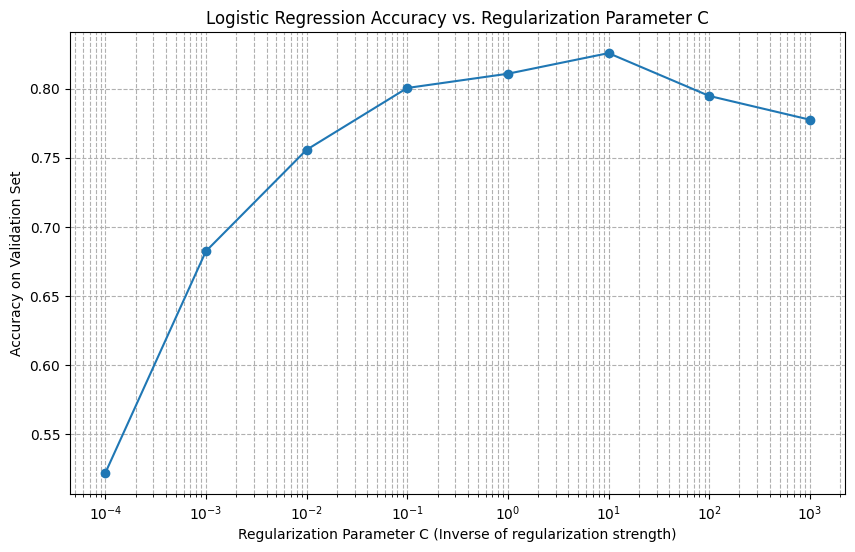


検証データで最も正解率が高かったのは C = 10.0 のときで、正解率は 0.8257 でした。


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# from sklearn.feature_extraction import DictVectorizer # vectorizerは既にロード済みのはず

# vectorizer, train_data_features, dev_data_features, logreg_model は
# 前の問題から引き継がれていると仮定します。

if 'vectorizer' not in locals() or \
   'train_data_features' not in locals() or not train_data_features or \
   'dev_data_features' not in locals() or not dev_data_features:
    print("エラー: 必要な変数 ('vectorizer', 'train_data_features', 'dev_data_features')")
    print("       が存在しないか、データが空です。")
    print("問題61および62を先に実行して、これらの変数とデータを準備してください。")
else:
    # 1. 学習データと検証データの特徴ベクトルとラベルを準備
    # 学習データ
    train_features_dicts = [item['feature'] for item in train_data_features]
    y_train = [int(item['label']) for item in train_data_features]
    X_train = vectorizer.transform(train_features_dicts) # fit_transformは問題62で実施済みなので、ここではtransformだけでも良いが、
                                                       # もしvectorizerが学習データでfitされていなければfit_transformが必要。
                                                       # 問題62でvectorizerは学習データにfit済みなので、X_trainも問題62のものを再利用可。

    # 検証データ
    dev_features_dicts = [item['feature'] for item in dev_data_features]
    y_dev_true = [int(item['label']) for item in dev_data_features]
    X_dev = vectorizer.transform(dev_features_dicts)

    # 2. 試行する正則化パラメータ C の範囲を設定
    # C の値は正則化の強さの「逆数」。小さいほど正則化が強い。
    c_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    # c_values = np.logspace(-4, 3, 8) # np.logspaceを使うと対数スケールで値を生成できる

    dev_accuracies = [] # 検証データの正解率を格納するリスト
    
    print("正則化パラメータCを変化させてモデルを学習し、検証データで評価します...")
    # 3. 各 C の値についてモデルを学習し、検証データで評価
    for c_param in c_values:
        print(f"  C = {c_param}: 学習中...")
        # ロジスティック回帰モデルのインスタンスを作成 (Cパラメータを指定)
        model = LogisticRegression(C=c_param, solver='liblinear', max_iter=1000, random_state=42)
        
        # モデルを学習
        model.fit(X_train, y_train)
        
        # 検証データで予測
        y_dev_pred = model.predict(X_dev)
        
        # 正解率を計算
        accuracy = accuracy_score(y_dev_true, y_dev_pred)
        dev_accuracies.append(accuracy)
        print(f"    検証データの正解率: {accuracy:.4f}")

    # 4. 結果のグラフ化
    plt.figure(figsize=(10, 6))
    plt.plot(c_values, dev_accuracies, marker='o')
    
    plt.xscale('log') # 横軸を対数スケールに
    plt.xlabel('Regularization Parameter C (Inverse of regularization strength)')
    plt.ylabel('Accuracy on Validation Set')
    plt.title('Logistic Regression Accuracy vs. Regularization Parameter C')
    plt.grid(True, which="both", ls="--") # グリッド線を表示 (主グリッドと補助グリッド)
    
    # 各点にCの値をテキスト表示（任意）
    # for i, c_val in enumerate(c_values):
    #     plt.text(c_val, dev_accuracies[i] + 0.001, f"C={c_val}\nAcc={dev_accuracies[i]:.3f}", ha='center', va='bottom', fontsize=8)

    plt.show()

    # 最も正解率が高かったCの値と、その時の正解率を表示
    if dev_accuracies:
        best_accuracy_idx = np.argmax(dev_accuracies)
        best_c = c_values[best_accuracy_idx]
        best_acc = dev_accuracies[best_accuracy_idx]
        print(f"\n検証データで最も正解率が高かったのは C = {best_c} のときで、正解率は {best_acc:.4f} でした。")